In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
import csv
from scipy import signal
import os.path 
from os import listdir
from os.path import isfile, join
from scipy.signal import savgol_filter
import copy

In [2]:
#Funcion que hace una lista de los archivos de una carpeta
def ls(ruta = '.'):
    return [arch for arch in listdir(ruta) if isfile(join(ruta, arch))]
#correr ls('.')

In [3]:
lista_archivo = ls('.')

##### Calibración

In [4]:
Cal = (2.5260+2.14594)/2

##### Diccionario

In [5]:
lista_archivo
with open(lista_archivo[18], 'rt') as f:
        reader = csv.reader(f)
        info = list(reader)
        for row in reader:
            print(row)

In [6]:
Lcil = {}
Ltot = {}
Masa = {}
Dmedio = {}

for i in info[1:]:
    Lcil[int(i[0])] = float(i[1])
    Ltot[int(i[0])] = float(i[2])
    Dmedio[int(i[0])] = float(i[3])
    Masa[int(i[0])] = float(i[4])

##### Funciones

In [7]:
def picosy(t,ym,nprc):
    #Cuentas para hallar la velocidad del Ym
    
    #resto recta
    gradient, intercept, r_value, p_value, std_err = stats.linregress(t,ym)
    nuevo = []
    for i,j in zip(t,ym):
        nuevo.append(j-gradient*i-intercept)
    #filtro
    nuevo2 = savgol_filter(nuevo, 51, 3)
    
    peakind = signal.find_peaks_cwt(nuevo2, np.arange(1,10),noise_perc=nprc)
    tpicos=[]
    ypicos=[]
    for j in peakind:
        tpicos.append(t[j])
        ypicos.append(ym[j])
    
    yperiod = []
    for i in range(len(tpicos)-1):
        yperiod.append(tpicos[i+1]-tpicos[i])
    return tpicos, ypicos, np.mean(yperiod)

In [8]:
def picosang(t,Ang,nprc):
    #filtro
    nuevo = savgol_filter(Ang, 51, 3)
    #busco picos
    peakind_Ang = signal.find_peaks_cwt(nuevo, np.arange(1,10),noise_perc=nprc)
    
    Ang_tpicos=[]
    Ang_picos=[]
    for j in peakind_Ang:
        Ang_tpicos.append(t[j])
        Ang_picos.append(Ang[j])

    Periodo_Ang = []
    for i in range(len(Ang_tpicos)-1):
        Periodo_Ang.append(Ang_tpicos[i+1]-Ang_tpicos[i])
    return Ang_tpicos, Ang_picos, np.mean(Periodo_Ang)

In [9]:
def analisis_de_cilindros(archivo,fps,Cal):
    
    with open(archivo, 'rt') as f:
        reader = csv.reader(f)
        data = list(reader)
        for row in reader:
            print(row)
 
    nro = float(archivo[6:8])
    
    tiempo = []
    Xm = []
    Ym = []
    ym = []
    Ang = []
    Angm = []
#     print(data[1][5]/Cal)
    for i in data[1:]:
        tiempo.append(float(i[0])/fps)
        Xm.append(float(i[5])/Cal)#-data[1][5]/Cal)
        Ym.append(float(i[6])/Cal)
        ym.append(-float(i[6])/Cal)
        Ang.append(float(i[9])-90)
        Angm.append(-(float(i[9])-90))
    
    #Calculo de la velocidad de sedimentacion del cilindro al descender verticalmente por la celda (vel de x centro de masa)          
    gradient, intercept, r_value, p_value, std_err = stats.linregress(tiempo,Xm)    

    tpicosM, ypicosM, Periodo_de_YM = picosy(tiempo,Ym,100) #Maximos
    tpicosm, ypicosm, Periodo_de_Ym= picosy(tiempo,ym,100) #Minimos
    ypicosm = -np.asarray(ypicosm)

    Ang_tpicosM, Ang_picosM, T_AngM = picosang(tiempo,Ang,100) #Maximos
    Ang_tpicosm, Ang_picosm, T_Angm = picosang(tiempo,Angm,100) #Minimos
    Ang_picosm = -np.asarray(Ang_picosm)
    
    Periodo_de_Y = (Periodo_de_YM+Periodo_de_Ym)/2
    T_Ang = (T_AngM+T_Angm)/2

    plt.figure(lista_archivo.index(archivo),figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(tiempo,Ym,label = 'Lcil = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(tpicosM,ypicosM,'r*')
    plt.plot(tpicosm,ypicosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,2)
    plt.plot(tiempo,Ang,label = 'L = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(Ang_tpicosM,Ang_picosM,'r*')
    plt.plot(Ang_tpicosm,Ang_picosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,3)
    plt.plot(tiempo,Xm,label = 'L = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.grid(b=True, which='major')
    plt.legend()
    
    LaPapa = [nro,tiempo,Xm,Ym,Ang,tpicosM,ypicosM,tpicosm,ypicosm,Ang_tpicosM,Ang_picosM,Ang_tpicosm,Ang_picosm]
    #ERRORES
    #tiempo
#     errT = 1/fps
    
#     T4 = 0
#     T12 = 0
#     for i in yperiod:
#         T4 = i**(-4)+T4
#     for i in range(len(yperiod)-1):
#         T12 = -2/((yperiod[i]*yperiod[i+1])**2) + T12
#     errfy = (1/fps)*np.sqrt((T4+T12)/len(yperiod)) 
    
#     T4 = 0
#     T12 = 0
#     for i in Periodo_Ang:
#         T4 = i**(-4)+T4
#     for i in range(len(Periodo_Ang)-1):
#         T12 = -2/(Periodo_Ang[i]*Periodo_Ang[i+1]) + T12
#     errfa = (1/fps)*np.sqrt((T4+T12)/len(Periodo_Ang)) 
    
    return nro, gradient, Periodo_de_Y, T_Ang, LaPapa  
#     return L, D, gradient, std_err, Periodo_de_Y, errfy, T_Ang, errfa      

1.0 -29.324592166373485 1.3547094188376754 1.2919171676686707
2.0 -31.03076660117787 1.4488977955911824 1.4245156980627924
3.0 -34.869784292353344 0.7370296147851259 1.0988643954575819
4.0 -34.2831853174721 0.5738750227728183 0.8429716576009162
5.0 -36.044051235017875 0.7247828991315965 1.0253841015364062
6.0 -35.66210957634113 0.6707860164773993 0.6976452905811623
7.0 -32.90049455231059 0.9018036072144289 0.8242874638165218
8.0 -31.070643083728505 1.0460921843687374 1.0333166332665331
9.0 -30.725458981085115 1.5522712090848363 1.2074148296593186
10.0 -31.014920017002954 1.3173012692050767 1.2920841683366735
12.0 -32.28973447633168 0.522354232274072 0.977132837102777
13.0 -33.8132379678044 0.7904698285459808 1.2792251169004678
14.0 -32.54172642818806 0.9507904698285459 0.9463371186818081
15.0 -32.48729817336312 1.218723160606928 1.1048287050291057


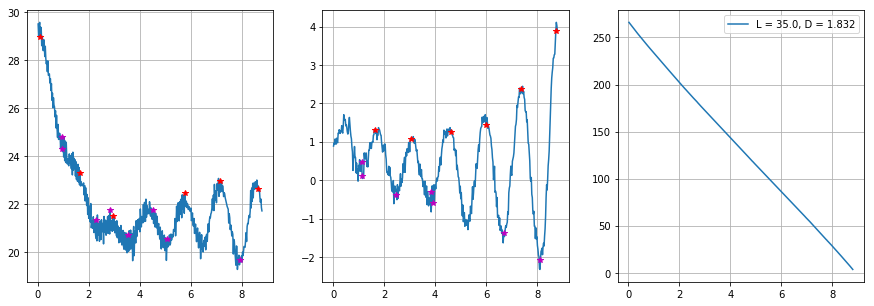

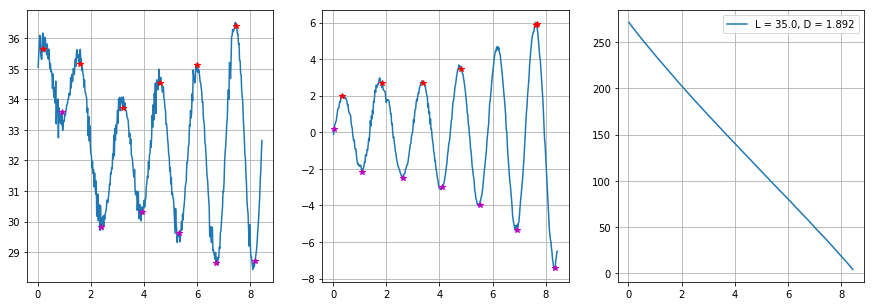

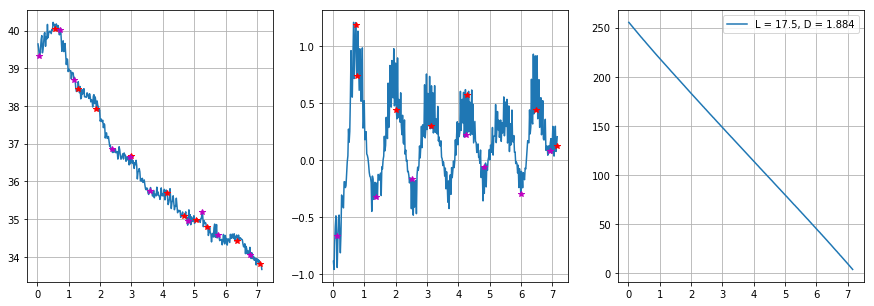

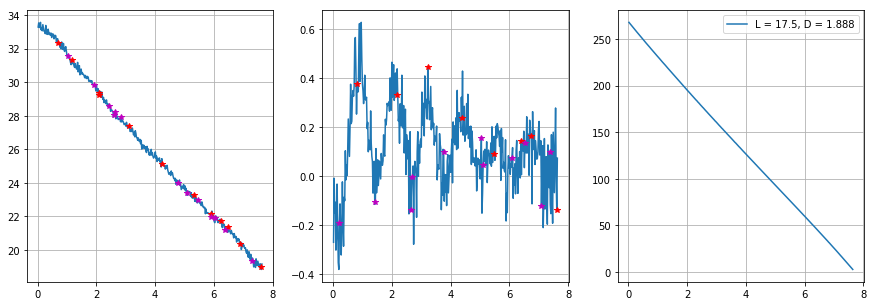

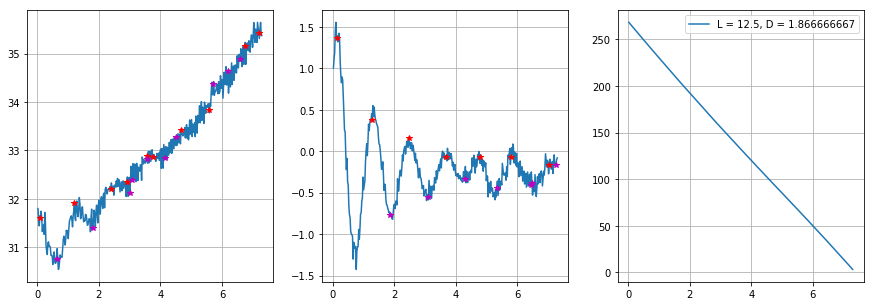

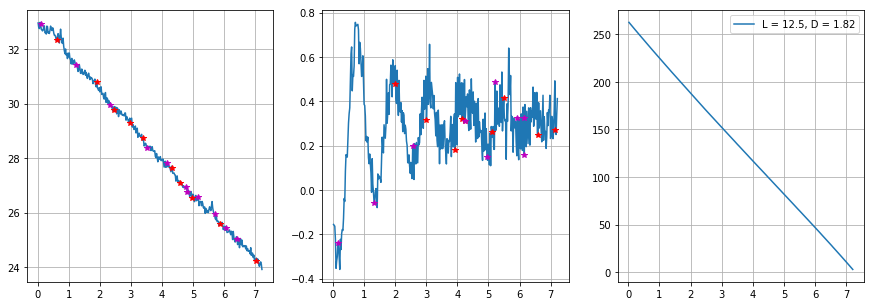

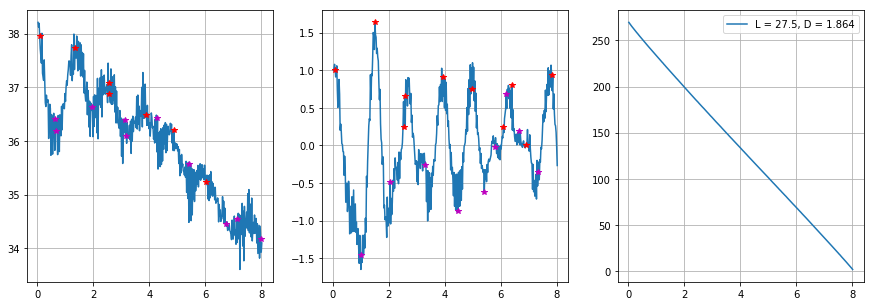

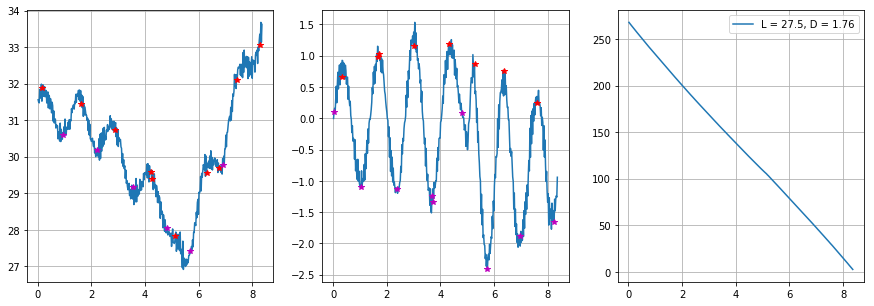

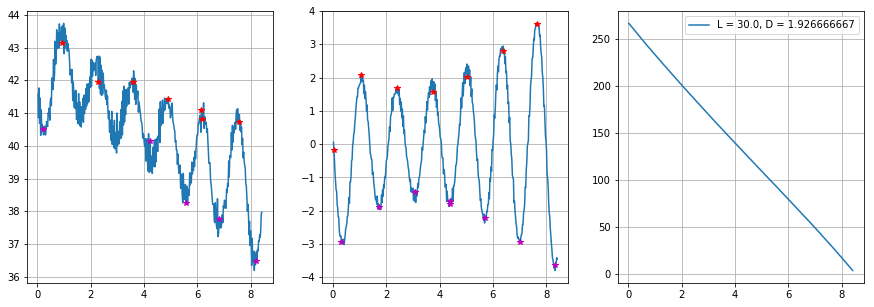

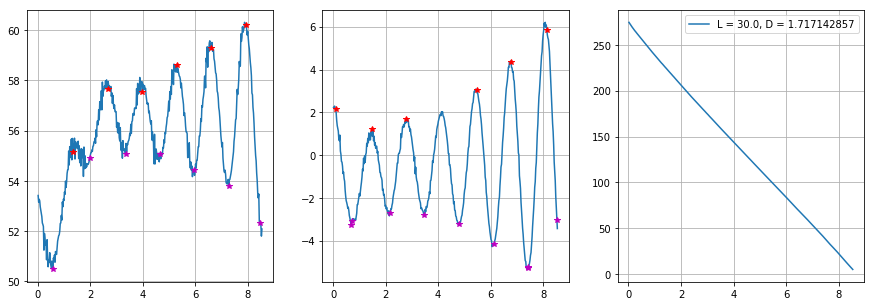

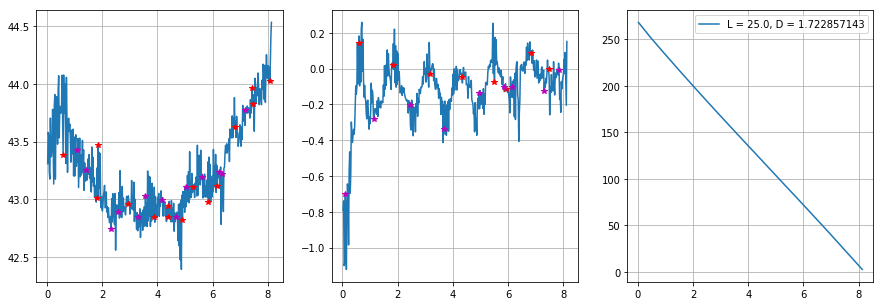

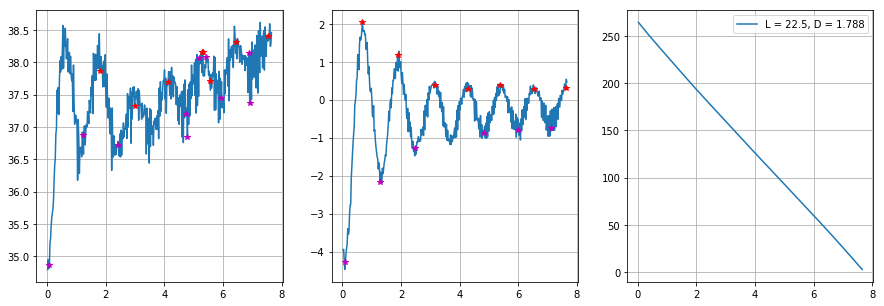

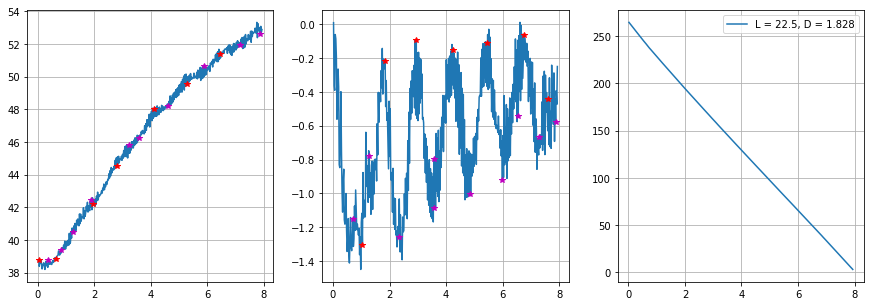

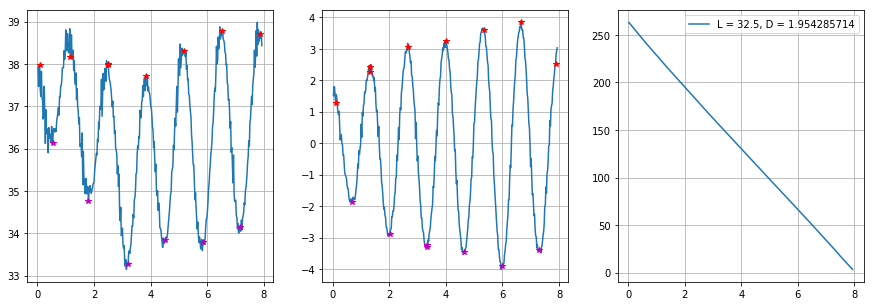

In [79]:
Discretos = []
MaximosY = {}
MinimosY = {}
MaximosA = {}
MinimosA = {}
tMaximosY = {}
tMinimosY = {}
tMaximosA = {}
tMinimosA = {}
Tiempo = {}
YCM = {}
XCM = {}
ANG = {}
VCM = {}
TY = {}
TA = {}
for i in range(14):
    nro, Vcm, Ty, Ta, dat = analisis_de_cilindros(lista_archivo[4+i],49.9,Cal)
    VCM[nro]=Vcm
    print(nro, Vcm, Ty, Ta)
    TY[nro]=Ty
    TA[nro]=Ta
    MaximosY[nro]=dat[6]
    tMaximosY[nro]=dat[5]
    MinimosY[nro]=dat[8]
    tMinimosY[nro]=dat[7]
    tMaximosA[nro] = dat[9]
    MaximosA[nro] = dat[10]
    tMinimosA[nro] = dat[11]
    MinimosA[nro] = dat[12]
    Tiempo[nro] = dat[1]
    YCM[nro] = dat[3]
    XCM[nro] = dat[2]
    ANG[nro] = dat[4]

#### Con los que hubo fluttering visible: 1, 2, 9, 10, 15

##### CilCon 1

In [80]:
#Correccion de minimos
copia = copy.deepcopy(MinimosA[1])
tcopia = copy.deepcopy(tMinimosA[1])
TCOPIA = copy.deepcopy(Tiempo[1])
COPIA = copy.deepcopy(ANG[1])
MinimosA[1][3]=copia[4]
tMinimosA[1][3]=tcopia[4]
i=67
MinimosA[1][4]=COPIA[TCOPIA.index(tcopia[4])+i]
tMinimosA[1][4]=TCOPIA[COPIA.index(copia[4])+i]

##### CilCon 2

In [81]:
#Correccion de maximos
i=72
copia = copy.deepcopy(MaximosA[2])
tcopia = copy.deepcopy(tMaximosA[2])
TCOPIA = copy.deepcopy(Tiempo[2])
COPIA = copy.deepcopy(ANG[2])
MaximosA[2][4]=COPIA[TCOPIA.index(tcopia[4])-i]
tMaximosA[2][4]=TCOPIA[COPIA.index(copia[4])-i]

##### CilCon 9

In [82]:
#Correccion minimos
a,b = MinimosA[9].tolist(), tMinimosA[9]
a.pop(3), b.pop(3)
MinimosA[9] = a
tMinimosA[9] = b

##### CilCon 10

In [83]:
#Correccion de maximos
i=67
copia = copy.deepcopy(MaximosA[10])
tcopia = copy.deepcopy(tMaximosA[10])
TCOPIA = copy.deepcopy(Tiempo[10])
COPIA = copy.deepcopy(ANG[10])
for j in range(2):
    MaximosA[10][j]=copia[j+1]
    tMaximosA[10][j]=tcopia[j+1]
MaximosA[10][2]=COPIA[TCOPIA.index(tcopia[2])+i]
tMaximosA[10][2]=TCOPIA[COPIA.index(copia[2])+i]

##### CilCon15

In [84]:
#Correccion minimos
a,b = MinimosA[15].tolist(), tMinimosA[15]
a.pop(3), b.pop(3)
MinimosA[15] = a
tMinimosA[15] = b

#Correccion maximos
c,d = MaximosA[15], tMaximosA[15]
c.pop(2), d.pop(2)
MaximosA[15] = c
tMaximosA[15] = d

### Ahora con los raros

##### CilCon 3

In [85]:
#Correccion de maximos

copia = copy.deepcopy(MaximosA[3])
tcopia = copy.deepcopy(tMaximosA[3])
TCOPIA = copy.deepcopy(Tiempo[3])
COPIA = copy.deepcopy(ANG[3])
MaximosA[3][6]=copia[5]
tMaximosA[3][6]=tcopia[5]

i=50
MaximosA[3][5]=COPIA[TCOPIA.index(tcopia[5])-i]
tMaximosA[3][5]=TCOPIA[COPIA.index(copia[5])-i]

a,b = MaximosA[3], tMaximosA[3]
a.pop(0), b.pop(0)
MaximosA[3] = a
tMaximosA[3] = b

In [86]:
#Correccion de minimos
copia = copy.deepcopy(MinimosA[3])
tcopia = copy.deepcopy(tMinimosA[3])
TCOPIA = copy.deepcopy(Tiempo[3])
COPIA = copy.deepcopy(ANG[3])

i=28
MinimosA[3][3]=COPIA[TCOPIA.index(tcopia[3])-i]
tMinimosA[3][3]=TCOPIA[COPIA.index(copia[3])-i]

a,b = MinimosA[3].tolist(), tMinimosA[3]
a.pop(0), b.pop(0)
MinimosA[3] = a
tMinimosA[3] = b

#### Frecuencias Raras

Largo Cilindro = 25.0 Largo total = 37.1 Diametro medio = 1.722857143


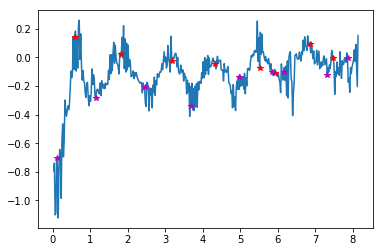

In [163]:
i=12
plt.plot(Tiempo[i],ANG[i])
plt.plot(tMaximosA[i],MaximosA[i],'*r')
plt.plot(tMinimosA[i],MinimosA[i],'*m')
# len(np.asarray(MaximosA[i])), len(np.asarray(MinimosA[i]))
print('Largo Cilindro = '+str(Lcil[i]), 'Largo total = '+str(Ltot[i]), 'Diametro medio = '+str(Dmedio[i]))

##### CilCon 3

In [167]:
frec=[]
t1=[]
t2=[]
for i in range(len(MaximosA[3])-1):
    t1.append(tMaximosA[3][i+1]-tMaximosA[3][i])
    t2.append(tMinimosA[3][i+1]-tMinimosA[3][i])
TA[3]=(np.mean(t1)+np.mean(t2))/2
TA[3]

1.1282565130260522

##### CilCon 4

In [168]:
frec=[]
t1=[tMinimosA[4][1]-tMinimosA[4][0],tMinimosA[4][2]-tMinimosA[4][1],tMinimosA[4][4]-tMinimosA[4][2]]
for i in range(len(MaximosA[4][:4])-1):
    t1.append(tMaximosA[4][i+1]-tMaximosA[4][i])
TA[4]=np.mean(t1)
TA[4]

1.1857047428189713

##### CilCon 5

In [175]:
frec=[]
t1=[]
for i in range(len(MaximosA[5][:-1])-1):
    t1.append(tMaximosA[5][i+1]-tMaximosA[5][i])
TA[5]=np.mean(t1)
TA[5]

1.134268537074148

##### CilCon 12

In [174]:
frec=[]
t1=[tMinimosA[12][2]-tMinimosA[12][1],tMinimosA[12][3]-tMinimosA[12][2]]
for i in range(len(MaximosA[12][:-3])-1):
    t1.append(tMaximosA[12][i+1]-tMaximosA[12][i])
    t2.append(tMinimosA[12][i+1]-tMinimosA[12][i])
TA[12]=np.mean(t1)

##### CilCon 13

In [169]:
frec=[]
t1=[tMinimosA[13][1]-tMinimosA[13][0],tMinimosA[13][2]-tMinimosA[13][1],tMinimosA[13][4]-tMinimosA[13][3],tMinimosA[13][5]-tMinimosA[13][4]]
for i in range(len(MaximosA[13][:-1])-1):
    t1.append(tMaximosA[13][i+1]-tMaximosA[13][i])
TA[13]=np.mean(t1)
TA[13]

1.169004676018704

##### CilCon 14

In [170]:
frec=[]
t1=[]
for i in range(len(MaximosA[14][1:-1])-1):
    t1.append(tMaximosA[14][i+1]-tMaximosA[14][i])
TA[14]=np.mean(t1)
TA[14]

1.097194388777555

### ---------------------------------------------------------------------------------------------------------------------------------------------------------

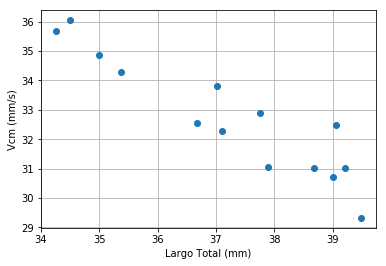

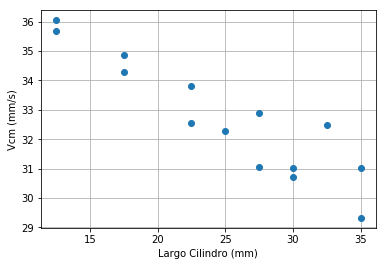

In [17]:
Velocidades=[]
LargosTot=[]
LargosCil=[]

for i in [1,2,3,4,5,6,7,8,9,10,12,13,14,15]:
    Velocidades.append(-np.asarray(VCM[i]))
    LargosTot.append(Ltot[i])
    LargosCil.append(Lcil[i])
plt.figure(1)
plt.plot(LargosTot,Velocidades,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Vcm (mm/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(LargosCil,Velocidades,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Vcm (mm/s)')
plt.grid(b=True, which='major')

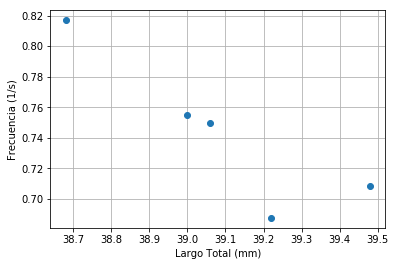

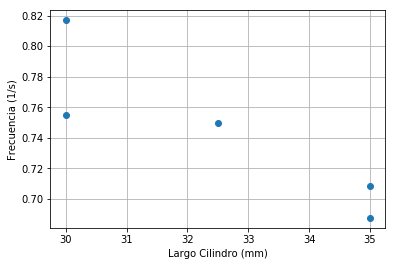

In [178]:
frecuenciasA = []
Lc = []
LT = []
for i in [1,2,9,10,15]:
    Lc.append(Lcil[i])
    LT.append(Ltot[i])
    PeriodoAm = []
    PeriodoAM = []
    for j in range(len(tMaximosA[i][1:-1])-1):
        PeriodoAM.append(tMaximosA[i][j+2]-tMaximosA[i][j+1])
    PerM = np.mean(PeriodoAM)
    for j in range(len(tMinimosA[i][1:-1])-1):
        PeriodoAm.append(tMinimosA[i][j+2]-tMinimosA[i][j+1])
    Perm = np.mean(PeriodoAm)
    TA[i]=(PerM+Perm)/2
    frecuenciasA.append(1/TA[i])    

plt.figure(1)
plt.plot(LT,frecuenciasA,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(Lc,frecuenciasA,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
    

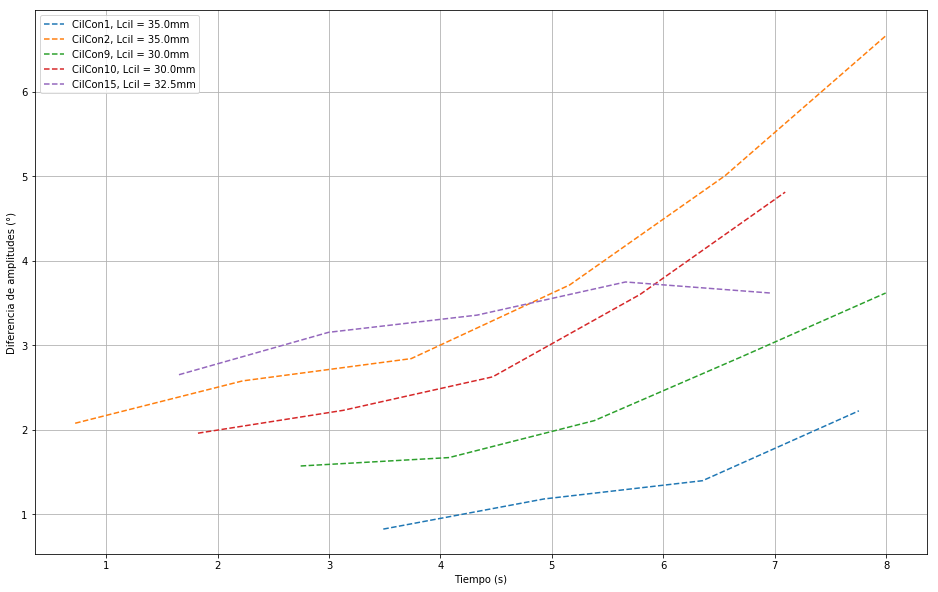

In [20]:
plt.figure(figsize=(16,10))
plt.plot((np.asarray(tMaximosA[1][1:-1])+np.asarray(tMinimosA[1][3:]))/2,(np.asarray(MaximosA[1][1:-1])-np.asarray(MinimosA[1][3:]))/2,'--',label='CilCon1, Lcil = '+str(Lcil[1])+'mm')
plt.plot((np.asarray(tMaximosA[2])+np.asarray(tMinimosA[2][1:]))/2,(np.asarray(MaximosA[2])-np.asarray(MinimosA[2][1:]))/2,'--',label='CilCon2, Lcil = '+str(Lcil[2])+'mm')
plt.plot((np.asarray(tMaximosA[9][2:])+np.asarray(tMinimosA[9][2:]))/2,(np.asarray(MaximosA[9][2:])-np.asarray(MinimosA[9][2:]))/2,'--',label='CilCon9, Lcil = '+str(Lcil[9])+'mm')
plt.plot((np.asarray(tMaximosA[10][:-1])+np.asarray(tMinimosA[10][2:-2]))/2,(np.asarray(MaximosA[10][:-1])-np.asarray(MinimosA[10][2:-2]))/2,'--',label='CilCon10, Lcil = '+str(Lcil[10])+'mm')
plt.plot((np.asarray(tMaximosA[15][1:-1])+np.asarray(tMinimosA[15][1:]))/2,(np.asarray(MaximosA[15][1:-1])-np.asarray(MinimosA[15][1:]))/2,'--',label='CilCon15, Lcil = '+str(Lcil[15])+'mm')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Diferencia de amplitudes (°)')
plt.grid(b=True, which='major')

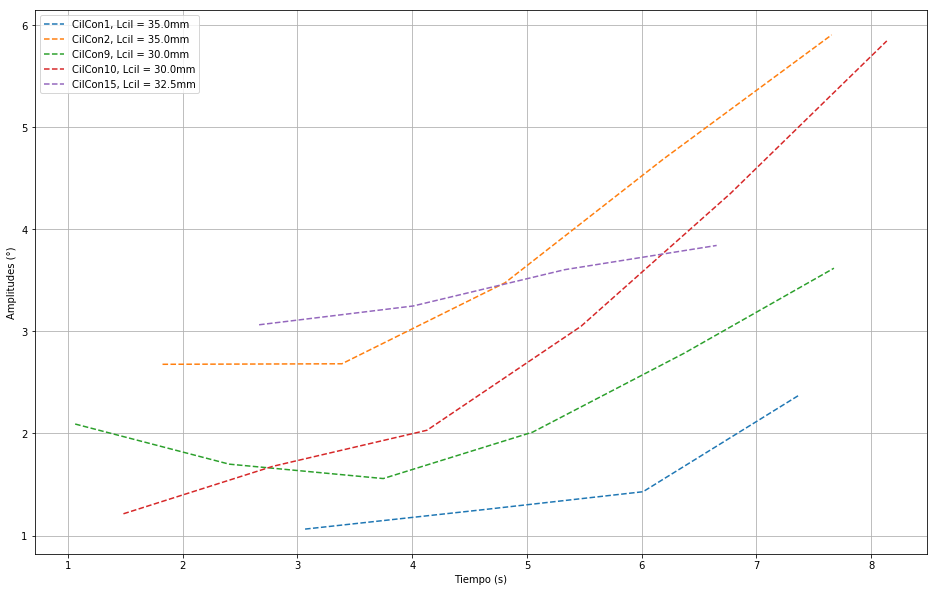

In [21]:
plt.figure(figsize=(16,10))
plt.plot(tMaximosA[1][1:-1],MaximosA[1][1:-1],'--',label='CilCon1, Lcil = '+str(Lcil[1])+'mm')
plt.plot(tMaximosA[2][1:],MaximosA[2][1:],'--',label='CilCon2, Lcil = '+str(Lcil[2])+'mm')
plt.plot(tMaximosA[9][1:],MaximosA[9][1:],'--',label='CilCon9, Lcil = '+str(Lcil[9])+'mm')
plt.plot(tMaximosA[10],MaximosA[10],'--',label='CilCon10, Lcil = '+str(Lcil[10])+'mm')
plt.plot(tMaximosA[15][2:-1],MaximosA[15][2:-1],'--',label='CilCon15, Lcil = '+str(Lcil[15])+'mm')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitudes (°)')
plt.grid(b=True, which='major')

### Con Raros

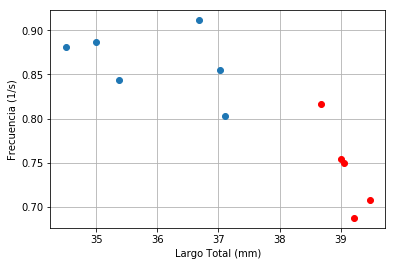

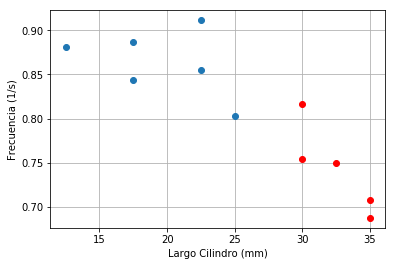

In [176]:
frecuenciasAR = []
LcR = []
LTR= []
for i in [3,4,5,12,13,14]:
    LcR.append(Lcil[i])
    LTR.append(Ltot[i])
    frecuenciasAR.append(1/TA[i])    

plt.figure(1)
plt.plot(LT,frecuenciasA,'ro')
plt.plot(LTR,frecuenciasAR,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(Lc,frecuenciasA,'ro')
plt.plot(LcR,frecuenciasAR,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')